# Kaggle
## Competição DSA de Machine Learning - Dezembro 2019

# Importando as bibliotecas

In [1]:
# Importar os principais pacotes
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

import time
import datetime
import gc

# Evitar que aparece os warnings
import warnings
warnings.filterwarnings("ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Variavel para controlar o treinamento no Kaggle
TRAIN_OFFLINE = True

In [1]:
# Importa os pacotes de algoritmos
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import lightgbm as lgb
from lightgbm.sklearn import LGBMRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor

# Importa pacotes do sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, log_loss
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.decomposition import PCA, FastICA, TruncatedSVD


/Users/rodrigolima82/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Carregando os dados de treino e teste

In [3]:
def read_data():
    
    if TRAIN_OFFLINE:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('../dataset/dataset_treino.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_teste.csv....')
        test = pd.read_csv('../dataset/dataset_teste.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
        
    else:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_treino.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_treino.csv....')
        test = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_teste.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
    
    return train, test

In [4]:
# Leitura dos dados
train, test = read_data()

Carregando arquivo dataset_treino.csv....
dataset_treino.csv tem 114321 linhas and 133 colunas
Carregando arquivo dataset_teste.csv....
dataset_teste.csv tem 114393 linhas and 132 colunas


# Feature Engineering

In [5]:
# Juntando os datasets de treino e teste para realizar todos os tratamentos nos dados
df = train.append(test)

In [6]:
# Transformando as features categorias com LabelEncoder
le = LabelEncoder()

for i, col in enumerate(df):
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(np.array(df[col].astype(str)).reshape((-1,)))
        
        
# Realizando tratamento de missing value
for c in df.columns:
    if c != 'ID' and c != 'target':
        df[c].fillna(df[c].mean(),inplace=True)


In [7]:
# Criando novas features atraces do PCA / ICA / GRP e SRP

n_comp = 4

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=42)
tsvd_results_df = tsvd.fit_transform(df.drop(columns = ['ID','target'], axis = 1))

# PCA
pca = PCA(n_components=n_comp, random_state=42)
pca2_results_df = pca.fit_transform(df.drop(columns = ['ID','target'], axis = 1))

# ICA
ica = FastICA(n_components=n_comp, random_state=42)
ica2_results_df = ica.fit_transform(df.drop(columns = ['ID','target'], axis = 1))

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=42)
grp_results_df = grp.fit_transform(df.drop(columns = ['ID','target'], axis = 1))

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=42)
srp_results_df = srp.fit_transform(df.drop(columns = ['ID','target'], axis = 1))


# Append dos componentes com o dataset
for i in range(1, n_comp+1):
    df['pca_' + str(i)]  = pca2_results_df[:,i-1]
    df['ica_' + str(i)]  = ica2_results_df[:,i-1]
    df['tsvd_' + str(i)] = tsvd_results_df[:,i-1]
    df['grp_' + str(i)]  = grp_results_df[:,i-1]
    df['srp_' + str(i)]  = srp_results_df[:,i-1] 

In [8]:
# Patronizacao dos dados
scaler = StandardScaler()
for c in df.columns:
    if c != 'ID' and c != 'target':
        df[c] = scaler.fit_transform(df[c].values.reshape(-1, 1))

In [9]:
df.head()

,ID,target,v1,v10,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v11,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v12,v120,v121,v122,v123,v124,v125,v126,v127,v128,v129,v13,v130,v131,v14,v15,v16,v17,v18,v19,v2,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v3,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v4,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v5,v50,v51,v52,v53,v54,v55,v56,v57,v58,v59,v6,v60,v61,v62,v63,v64,v65,v66,v67,v68,v69,v7,v70,v71,v72,v73,v74,v75,v76,v77,v78,v79,v8,v80,v81,v82,v83,v84,v85,v86,v87,v88,v89,v9,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99,pca_1,ica_1,tsvd_1,grp_1,srp_1,pca_2,ica_2,tsvd_2,grp_2,srp_2,pca_3,ica_3,tsvd_3,grp_3,srp_3,pca_4,ica_4,tsvd_4,grp_4,srp_4
0,3,1.0,-3.630884e-01,-0.988587,1.426492e+00,8.664723e-01,-9.985041e-02,-9.993504e-01,-1.603550e+00,-6.321401e-01,3.597110e-01,1.182075,3.363053e-01,-8.765501e-02,1.667904e+00,0.831485,-2.622701e+00,0.883153,0.844842,0.788076,-5.395886e+00,-6.744603e-01,-6.212775e-01,-1.628388e+00,-1.002128e+00,-0.860860,-4.218365e-01,-1.897890e+00,8.740917e-01,-8.049388e-01,-5.557083e-01,-0.971775,3.479667e-01,-1.025077e-01,-6.394812e-03,-0.447656,-1.055068e+00,-1.357901e+00,1.313722e+00,-0.318839,-1.320749e+00,2.718014e+00,-1.088830e-01,-1.523347e+00,-6.007835e-01,5.758824e-01,1.262254e+00,0.655297,1.407234,-3.665499e-01,-0.947545,-6.977245e-01,-3.713495e-01,1.045534e+00,-2.233208e+00,6.972928e-01,-0.134466,-1.310776,-0.468331,-1.271144e+00,-1.555671e+00,0.426663,2.527878e-01,-1.142042e+00,-7.136852e-01,-0.15536,1.549473e+00,-2.574366e-01,-0.869074,6.226219e-01,-2.945532e-01,-4.115180e-01,-1.838857e-01,4.581655e-01,-6.931760e-01,-0.926604,-2.261067e-01,1.007197e-01,-5.330178e-01,-0.519972,4.165406e-02,0.127292,1.730589e+00,-6.953976e-01,-4.170095e-01,0.564731,-2.097269e-01,-1.396141e+00,1.977376e-01,3.660054e-01,-3.086479e-01,8.031786e-01,-0.044084,-6.836550e-01,1.464511e-02,1.740320e+00,1.676532,2.978146e-02,-1.340124e+00,5.394183e+00,1.563350e+00,-2.760003e-01,0.713931,-0.466302,-1.366136e+00,-0.071457,0.721636,-1.639394e-01,-1.613851e-02,-3.445916e+00,-0.007392,-7.042218e-01,9.827842e-01,1.430320e-01,9.460638e-01,-1.908728e+00,-4.379935e-01,-1.050689e+00,-1.006735e+00,-0.274443,1.776152e+00,-6.707387e-01,6.690789e-01,-4.153842e-01,-1.120052,-7.102480e-01,2.788122e-01,-5.231948e-01,-9.519235e-01,1.162310e+00,-1.495501e+00,6.861507e-01,-1.679475e-01,-1.407234,-0.825555,1.407240,-1.408983,0.522212,-0.523785,0.968736,-1.089817,1.407897,1.174206,0.929380,-1.384258,-1.180599,1.409779,-1.915372,-1.068187,0.850453,0.423371,-1.468680,-1.579103
1,4,1.0,7.954795e-15,-0.408365,6.176752e-15,-7.046277e-15,5.888360e-15,-1.245498e-14,1.063419e-14,2.466274e-01,-8.817948e-15,-0.944226,-4.703689e-01,2.486966e-02,-2.071239e-13,-0.980198,-8.332144e-15,1.895383,-0.837254,-1.248775,-8.724587e-15,1.500754e-14,8.369273e-01,4.710601e-15,2.104422e-15,-0.403811,-1.480779e-14,-3.915604e-15,-4.748429e-14,-2.468963e-14,-2.054999e-01,-1.562332,2.878056e-14,7.283738e-16,-8.815310e-02,-0.447656,6.349561e-14,-3.731841e-15,-1.433347e-14,-0.318840,5.161091e-14,-1.983033e-15,1.391286e-14,1.673773e-14,-9.962328e-15,8.810249e-15,-2.861879e-14,-0.254933,-0.285476,-1.487179e-16,-0.947545,6.045598e-01,7.989758e-15,-2.134595e-15,-7.038195e-15,-3.675856e-14,-0.134466,-1.310776,-0.468331,-3.238515e-14,1.078469e-14,-1.377077,-4.940844e-14,6.784169e-01,-6.637295e-15,-0.15536,-3.730691e-15,-5.249095e-14,1.210973,2.707225e-14,-1.422414e-14,6.396400e-15,-1.906794e-14,-3.440786e-15,3.712525e-01,-0.215868,3.880234e-14,2.881384e-14,2.905725e-01,-0.108741,6.630060e-15,0.127292,-5.926474e-15,-7.178966e-02,-1.415719e-14,0.996858,5.066698e-14,-3.628367e-15,-3.422120e-14,-3.985387e-14,-4.257855e-14,1.338809e-14,1.393197,3.795131e-01,1.593135e-14,2.639165e-14,-0.735050,3.367882e-14,-3.690428e-14,-5.480561e-14,-3.001727e-15,-1.232556e-01,0.713931,0.620619,-8.880828e-15,-0.071457,0.721636,-1.408071e-14,6.385912e-14,2.053849e-14,-0.269623,3.764205e-01,2.427466e-14,-5.124276e-03,-9.999872e-01,-1.609635e-14,-3.303785e-14,8.393837e-15

# Criar e avaliar alguns algoritmos de Machine Learning

In [50]:
# Separa dataset de treino e teste depois de aplicar Feature Engineering
treino = df[df['target'].notnull()]
teste = df[df['target'].isnull()]

# Separando features preditoras e target
train_x = treino.drop(['ID','target'], axis=1)
train_y = treino['target']

# Removendo ID dataset de teste
test_x = teste.drop(['ID','target'], axis=1)

# Algoritmo XGBoost - Extreme Gradient Boosting

In [2]:
# Criando uma funcao para criação, execução e validação do modelo
def run_model_xgb(X_tr, y_tr, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    
    # Criando o modelo XGB com todas as otimizações
    modelo = XGBClassifier(learning_rate = 0.1, 
                              n_estimators = 10, 
                              max_depth = 4,
                              min_child_weight = 1, 
                              gamma = 0, 
                              subsample = 0.7, 
                              colsample_bytree = 0.6,
                              reg_alpha = 0.005,
                              objective = 'binary:logistic', 
                              n_jobs = -1,
                              scale_pos_weight = 1, 
                              seed = 42)

    # Utilização do Cross-Validation
    if useTrainCV:
        xgb_param = modelo.get_xgb_params()
        xgtrain = xgb.DMatrix(X_tr, label=y_tr)
        
        print ('Start cross validation')
        cvresult = xgb.cv(xgb_param, 
                          xgtrain, 
                          num_boost_round=modelo.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics=['logloss'],
                          stratified=True,
                          seed=42,
                          verbose_eval=True,
                          early_stopping_rounds=early_stopping_rounds)

        modelo.set_params(n_estimators=cvresult.shape[0])
        best_tree = cvresult.shape[0]
        print('Best number of trees = {}'.format(best_tree))
    
    # Fit do modelo
    modelo.fit(X_tr, y_tr, eval_metric='logloss')
        
    # Predição no dataset de treino
    train_pred = modelo.predict(X_tr)
    train_pred_prob = modelo.predict_proba(X_tr)[:,1]
    
    # Exibir o relatorio do modelo
    print("Log Loss (Treino): %f" % log_loss(y_tr, train_pred_prob))
    print("Log Loss (Test): %f" % cvresult['test-logloss-mean'][best_tree-1])
    
    return modelo

In [3]:
%%time

modeloXGB = run_model_xgb(train_x, train_y)

NameError: name 'train_x' is not defined

# Algoritmo LightGBM

In [25]:
# Configurações Gerais
STRATIFIED_KFOLD = False
RANDOM_SEED = 737851
NUM_THREADS = 4
NUM_FOLDS = 10
EARLY_STOPPING = 1000

LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',#'gbdt',
    'n_estimators': 100,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
    'verbose':-1
}

In [55]:
def run_model_lgb(data):
    df = data[data['target'].notnull()]
    test = data[data['target'].isnull()]
    del_features = ['ID','target']
    predictors = list(filter(lambda v: v not in del_features, df.columns))
    
    print("Train/valid shape: {}, test shape: {}".format(df.shape, test.shape))

    if not STRATIFIED_KFOLD:
        folds = KFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)
    else:
        folds = StratifiedKFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)

    oof_preds = np.zeros(df.shape[0])
    sub_preds = np.zeros(test.shape[0])
    importance_df = pd.DataFrame()
    eval_results = dict()
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[predictors], df['target'])):
        train_x, train_y = df[predictors].iloc[train_idx], df['target'].iloc[train_idx]
        valid_x, valid_y = df[predictors].iloc[valid_idx], df['target'].iloc[valid_idx]

        params = {'random_state': RANDOM_SEED, 'nthread': NUM_THREADS}
        
        clf = LGBMClassifier(**{**params, **LIGHTGBM_PARAMS})
        
        clf.fit(train_x, train_y, 
                eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric='logloss', 
                verbose=400, 
                early_stopping_rounds= EARLY_STOPPING)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test[predictors], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        print('Fold %2d Log Loss : %.6f' % (n_fold + 1, log_loss(valid_y, oof_preds[valid_idx])))
        del train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full Log Loss score %.6f' % log_loss(df['target'], oof_preds))
        
    return clf

In [56]:
%%time

modeloLGB = run_model_lgb(df)

Train/valid shape: (114321, 153), test shape: (114393, 153)
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.508863	valid_1's binary_logloss: 0.506757
Fold  1 Log Loss : 0.506757
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.508549	valid_1's binary_logloss: 0.511083
Fold  2 Log Loss : 0.511083
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.508323	valid_1's binary_logloss: 0.51156
Fold  3 Log Loss : 0.511560
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.508563	valid_1's binary_logloss: 0.508024
Fold  4 Log Loss : 0.508024
Training until validation scores don't improve for 1000 rounds
Did not meet e

# Submissions

In [61]:
# Submission XGB
submissionXGB = pd.read_csv('../dataset/sample_submission.csv')
submissionXGB['PredictedProb'] = modeloXGB.predict_proba(test_x)[:,1]

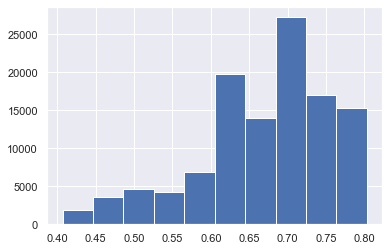

In [62]:
plt.hist(submissionXGB.PredictedProb)
plt.show()

In [63]:
# Submission LGB
submissionLGB = pd.read_csv('../dataset/sample_submission.csv')
submissionLGB['PredictedProb'] = modeloLGB.predict_proba(test_x)[:,1]

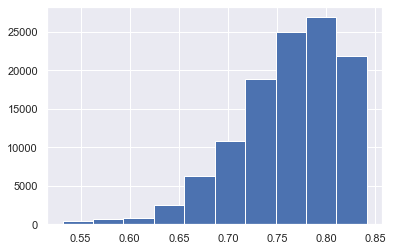

In [64]:
plt.hist(submissionLGB.PredictedProb)
plt.show()

# Ensemble Submissions

In [65]:
submissionEnsemble = pd.read_csv('../dataset/sample_submission.csv')
submissionEnsemble['PredictedProb'] = submissionXGB['PredictedProb'] * 0.7 + submissionLGB['PredictedProb'] * 0.3
submissionEnsemble.to_csv('submission_ensemble_v1.0.6.csv', index=False)

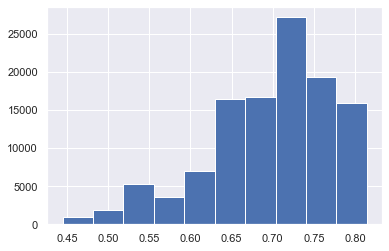

In [66]:
plt.hist(submissionEnsemble.PredictedProb)
plt.show()